# Time Series Analysis – Gauge Data
**Gauge Units**: **feet**

**Goals**
- Predict minor, moderate, and major flood stages over the next 1+ years
- Based on this [SARIMA modeling article](https://github.com/marcopeix/time-series-analysis/tree/master/Advanced%20modelling)
- Based on this [Kaggle Notebook](https://www.kaggle.com/code/sandhyakrishnan02/time-series-analysis-and-forecasting)

**Procedure**
- Data Cleanup
- Visual Stationarity check
- ADF Test
- SARIMA Modeling

In [76]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import seaborn as sns # Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt # Visualization
%matplotlib inline
mpl.rcParams['figure.dpi'] = 150

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

import math

import warnings # Supress warnings 
warnings.filterwarnings('ignore')

# https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing

from tqdm import tqdm_notebook
from ipywidgets import FloatProgress

from datetime import date

from itertools import product

np.random.seed(0)
sns.set()

Exception ignored in: <function tqdm.__del__ at 0x1261c7e20>
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/std.py", line 1162, in __del__
    self.close()
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/notebook.py", line 288, in close
    self.disp(bar_style='danger', check_delay=False)
AttributeError: 'tqdm_notebook' object has no attribute 'disp'
Exception ignored in: <function tqdm.__del__ at 0x1261c7e20>
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/std.py", line 1162, in __del__
    self.close()
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/notebook.py", line 288, in close
    self.disp(bar_style='danger', check_delay=False)
AttributeError: 'tqdm_notebook' object has no attribute 'disp'
Exception ignored in: <function tqdm.__del

In [3]:
gauge = pd.read_csv("Data/Daily_Max_Vals.csv", index_col=0)
gauge.head()

,date,stid,gauge,discharge,rainfall_inches,rainfall_ft
0,2007-10-01,RA101,2.40,23.9,0.0,0.0
1,2007-10-02,RA101,2.39,23.2,0.0,0.0
2,2007-10-03,RA101,2.39,23.2,0.0,0.0
3,2007-10-04,RA101,2.39,23.2,0.0,0.0
4,2007-10-05,RA101,2.42,25.2,0.0,0.0


In [4]:
gauge = gauge[['date', 'gauge']]
gauge.head()

,date,gauge
0,2007-10-01,2.40
1,2007-10-02,2.39
2,2007-10-03,2.39
3,2007-10-04,2.39
4,2007-10-05,2.42


Since this is a TimeSeries problem, we have to parse 'date' column

In [5]:
gauge['date'] = pd.to_datetime(gauge['date'], infer_datetime_format=True)
gauge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5477 entries, 0 to 5476
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    5477 non-null   datetime64[ns]
 1   gauge   5477 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 128.4 KB


In [6]:
# No null values!
gauge.isnull().sum()

date     0
gauge    0
dtype: int64

<AxesSubplot:xlabel='date', ylabel='gauge'>

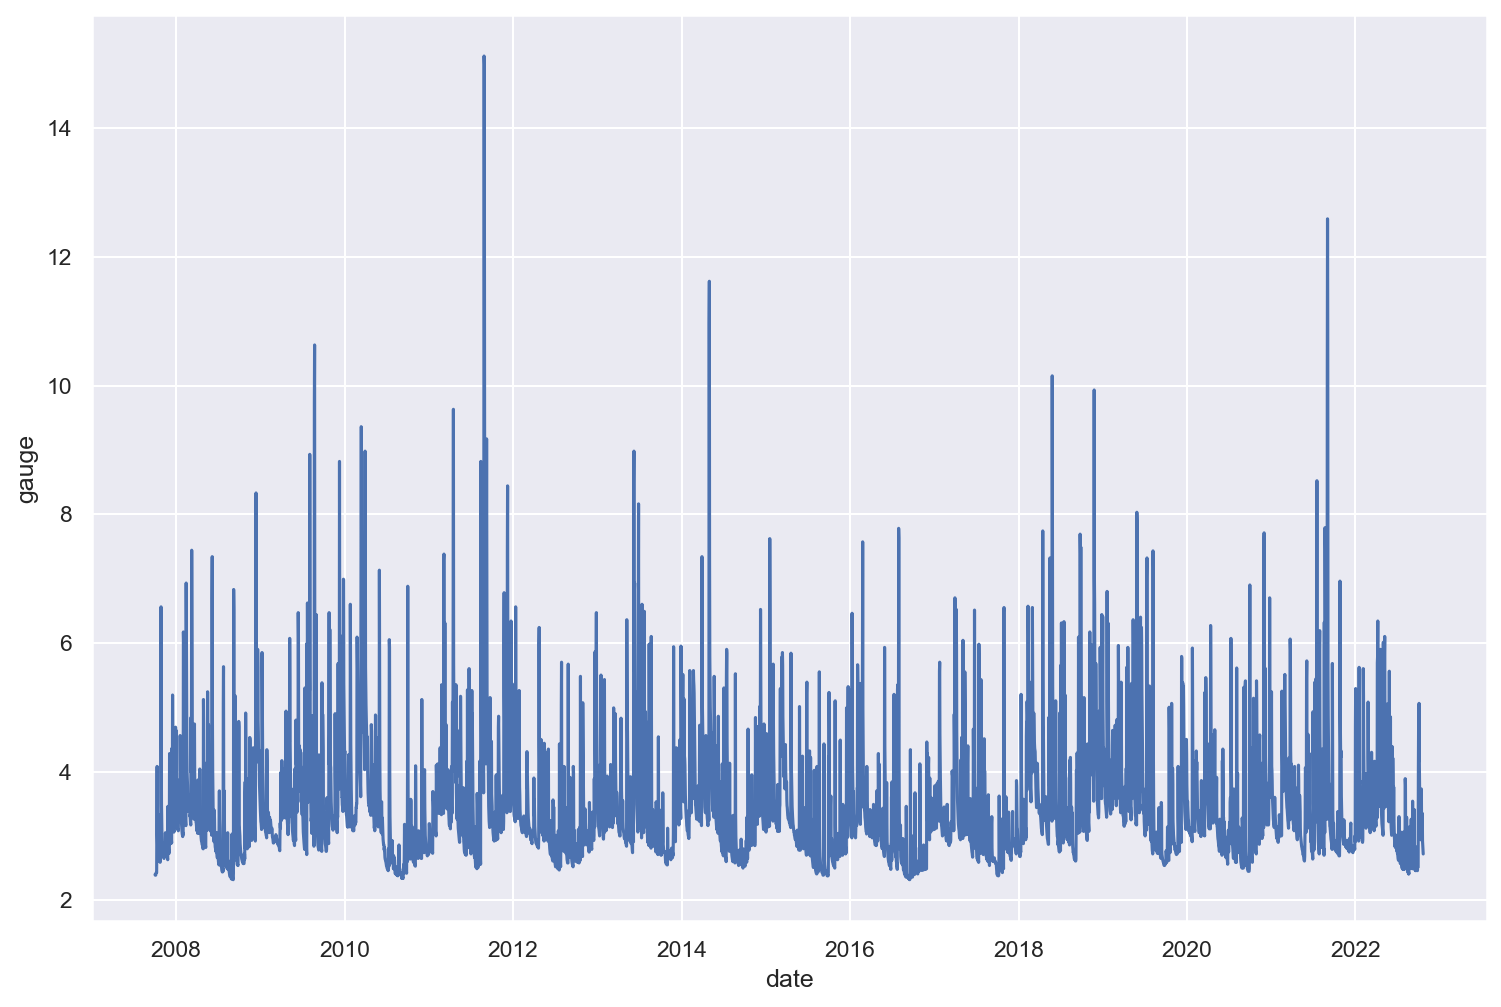

In [7]:
plt.figure(figsize=(12,8), dpi=150)
sns.lineplot(x=gauge['date'], y=gauge['gauge'])

## Stationarity

Some time-series models such as ARIMA assume that the underlying data is stationary. Stationarity describes that the time-series has

* constant mean and mean is not time-dependent
* constant variance and variance is not time-dependent
* constant covariance and covariance is not time-dependent

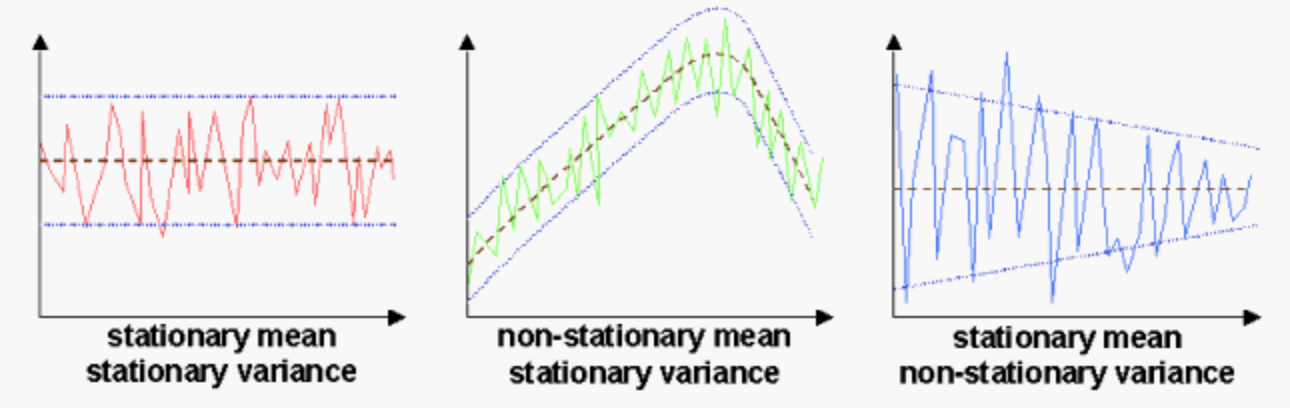

The check for stationarity can be done via three different approaches:

1. **visually**: plot time series and check for trends or seasonality
2. **basic statistics**: split time series and compare the mean and variance of each partition
3. **statistical test**: Augmented Dickey Fuller test

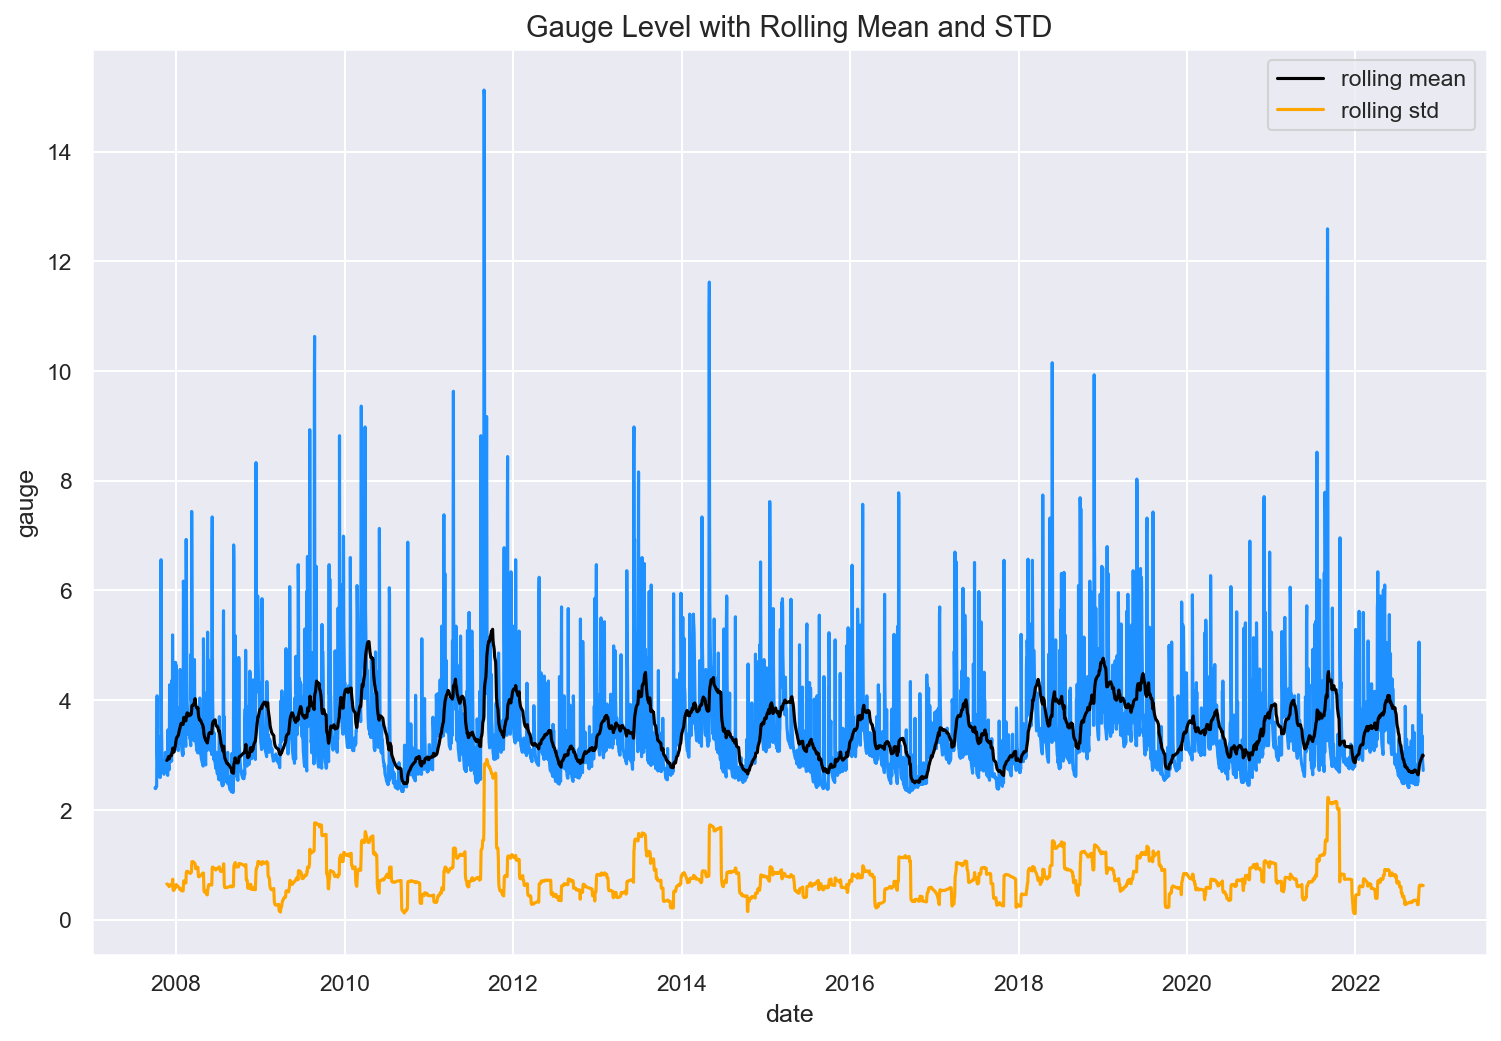

In [8]:
rolling_window = 52
plt.figure(figsize=(12,8), dpi=150)

sns.lineplot(x=gauge['date'], y=gauge['gauge'], color='dodgerblue')
sns.lineplot(x=gauge['date'], y=gauge['gauge'].rolling(rolling_window).mean(), color='black', label='rolling mean')
sns.lineplot(x=gauge['date'], y=gauge['gauge'].rolling(rolling_window).std(), color='orange', label='rolling std')
		 
plt.title('Gauge Level with Rolling Mean and STD', fontsize=14)
plt.show()

In this **visual check**, we can see that the **features don't have constant mean and std**, but they are close to it.

## Augmented Dickey-Fuller (ADF)

**Augmented Dickey-Fuller (ADF)** test is a unit root test. Unit roots (complex roots >= 1) are a cause for non-stationarity.

- Null Hypothesis (H0): Time series has a unit root. (Time series is not stationary).

- Alternate Hypothesis (H1): Time series has no unit root (Time series is stationary).

**If the null hypothesis can be rejected, we can conclude that the time series is stationary.**

There are two ways to reject the null hypothesis:

On the one hand, the null hypothesis can be rejected if the p-value is below a set significance level. The defaults significance level is 5%

* <font color='red'>**p-value > significance level (default: 0.05)**</font>: Fail to reject the null hypothesis (H0), the data has a unit root and is <font color='red'>non-stationary</font>.
* <font color='green'>**p-value <= significance level (default: 0.05)**</font>: Reject the null hypothesis (H0), the data does not have a unit root and is <font color='green'>stationary</font>.
    
On the other hand, the null hypothesis can be rejects if the test statistic is less than the critical value.
* <font color='red'>**ADF statistic > critical value**</font>: Fail to reject the null hypothesis (H0), the data has a unit root and is <font color='red'>non-stationary</font>.
* <font color='green'>**ADF statistic < critical value**</font>: Reject the null hypothesis (H0), the data does not have a unit root and is <font color='green'>stationary</font>.

In [9]:
result = adfuller(gauge['gauge'].values)
result

(-11.419242324455748,
 6.938960764602319e-21,
 14,
 5462,
 {'1%': -3.43154779858949,
  '5%': -2.8620693073079546,
  '10%': -2.5670517492274776},
 11542.911032674094)

Now, we are going to check for each variable:
* The p-value is less than 0.05
* Check the range of the ADF statistic compared with critical_values 

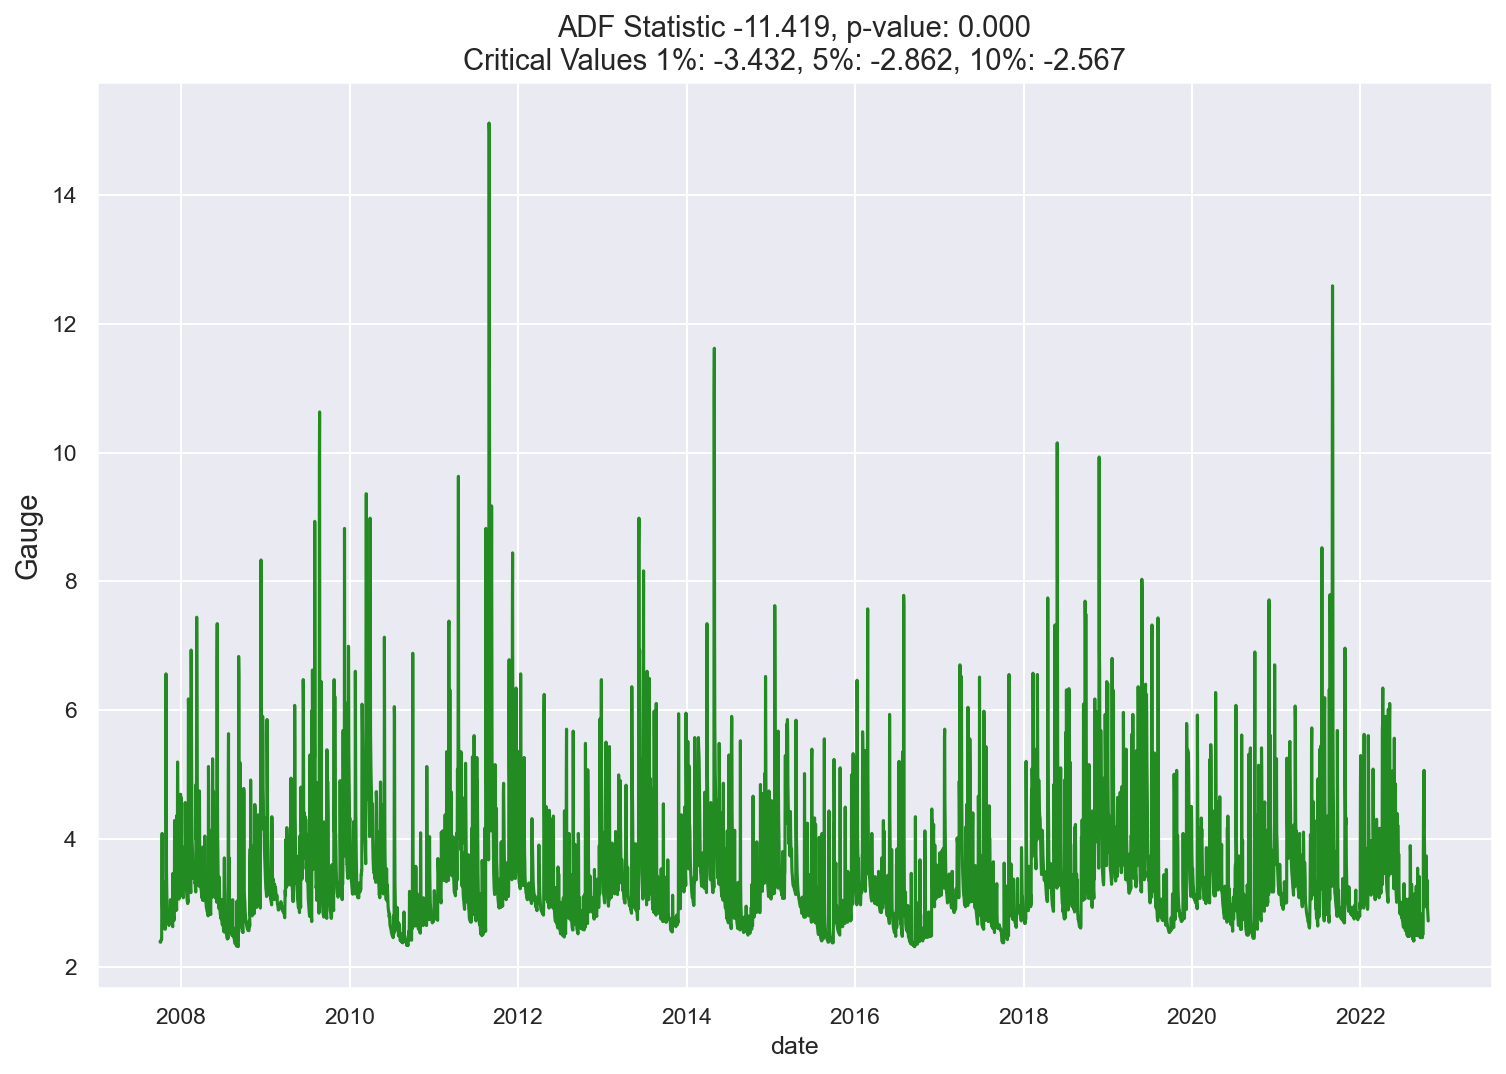

In [10]:
# Thanks to https://www.kaggle.com/iamleonie for this function!
plt.figure(figsize=(12,8), dpi=150)

def visualize_adfuller_results(series, title):
    result = adfuller(series)
    significance_level = 0.05
    adf_stat = result[0]
    p_val = result[1]
    crit_val_1 = result[4]['1%']
    crit_val_5 = result[4]['5%']
    crit_val_10 = result[4]['10%']

    if (p_val < significance_level) & ((adf_stat < crit_val_1)):
        linecolor = 'forestgreen' 
    elif (p_val < significance_level) & (adf_stat < crit_val_5):
        linecolor = 'orange'
    elif (p_val < significance_level) & (adf_stat < crit_val_10):
        linecolor = 'red'
    else:
        linecolor = 'purple'
    sns.lineplot(x=gauge['date'], y=series, color=linecolor)
    plt.title(f'ADF Statistic {adf_stat:0.3f}, p-value: {p_val:0.3f}\nCritical Values 1%: {crit_val_1:0.3f}, 5%: {crit_val_5:0.3f}, 10%: {crit_val_10:0.3f}', fontsize=14)
    plt.ylabel(ylabel=title, fontsize=14)

visualize_adfuller_results(gauge['gauge'], 'Gauge')
plt.show()

### The low p-value means we reject H0 and our data is stationary!
If our data were not stationary, it would need to be transformed using log, square root, or differencing.

However, it looks like our stationarity checks went well, so we can skip this transformation step!

## TimeSeries Decomposition

Time series decomposition breaks a series into components: level, trend, seasonality, and noise.

These components are defined as follows:

* **Level**: The average value in the series.
* **Trend**: The increasing or decreasing value in the series.
* **Seasonality**: The repeating short-term cycle in the series.
* **Noise**: The random variation in the series.

Decomposition provides a useful abstract model for thinking about time series generally and for better understanding problems during time series analysis and forecasting.

All series have a level and noise. The trend and seasonality components are optional.

It is helpful to think of the components as combining either additively or multiplicatively:
* **Additive**: $y(t) = Level + Trend + Seasonality + Noise$
* **Multiplicative**: $y(t) = Level * Trend * Seasonality * Noise$

In this case we are going to use seasonal_decompose() from the [statsmodels](https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.seasonal_decompose.html) library.

In [11]:
# 1 week, 2 weeks, 1 month, 3 months, 6 months, 1 year, 2, 3, 4, 5 years
periods = [7, 14, 30, 90, 180, 365, 730, 1095, 1460, 1825]

In [12]:
def plot_decomp(per=int):
	decomp = seasonal_decompose(gauge['gauge'], period=per, model='additive', extrapolate_trend='freq')
	gauge[f"gauge_trend"] = decomp.trend
	gauge[f"gauge_seasonal"] = decomp.seasonal
	decomp.plot()
	# Get current figure and adjust size; regular adjustment not working
	plt.gcf().set_size_inches(12, 12)
	print(f'Gauge, Period: {per} Days')
	plt.show()

Gauge, Period: 7 Days


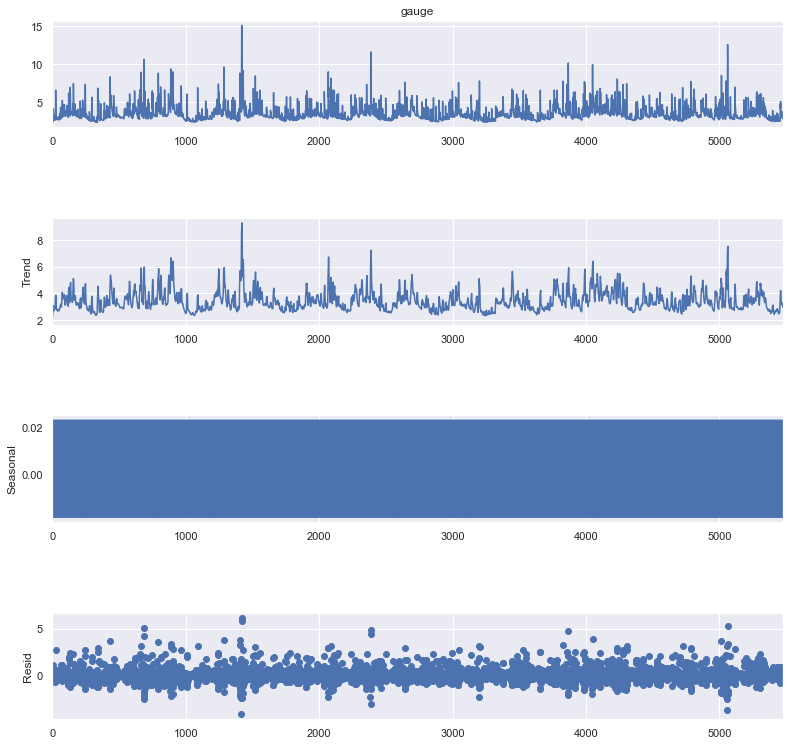

Gauge, Period: 14 Days


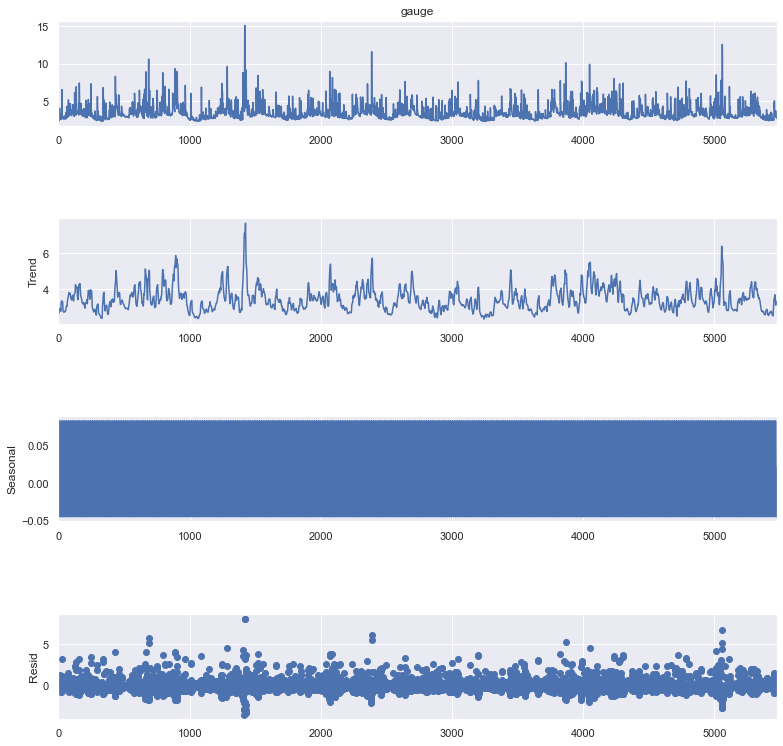

Gauge, Period: 30 Days


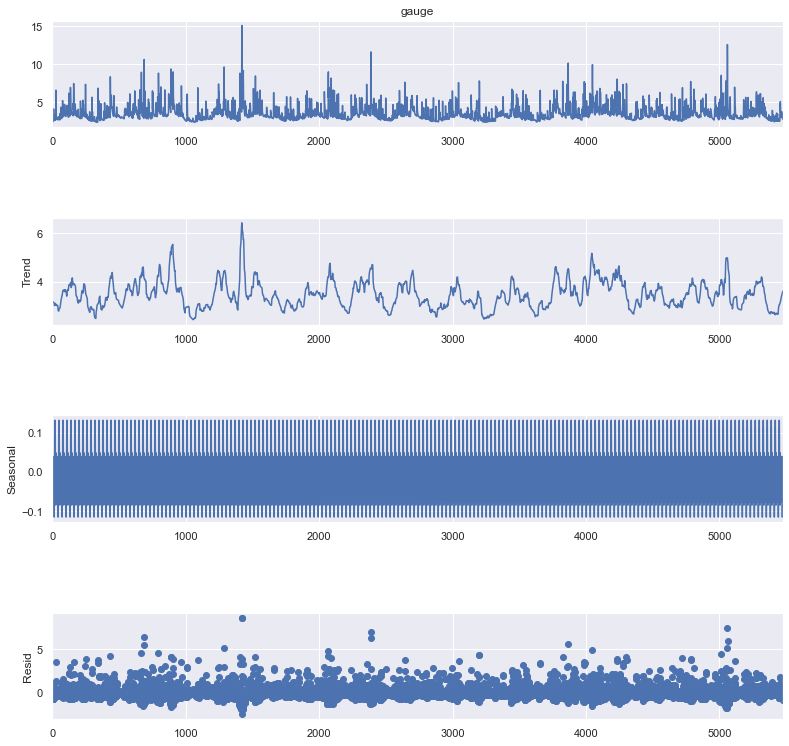

Gauge, Period: 90 Days


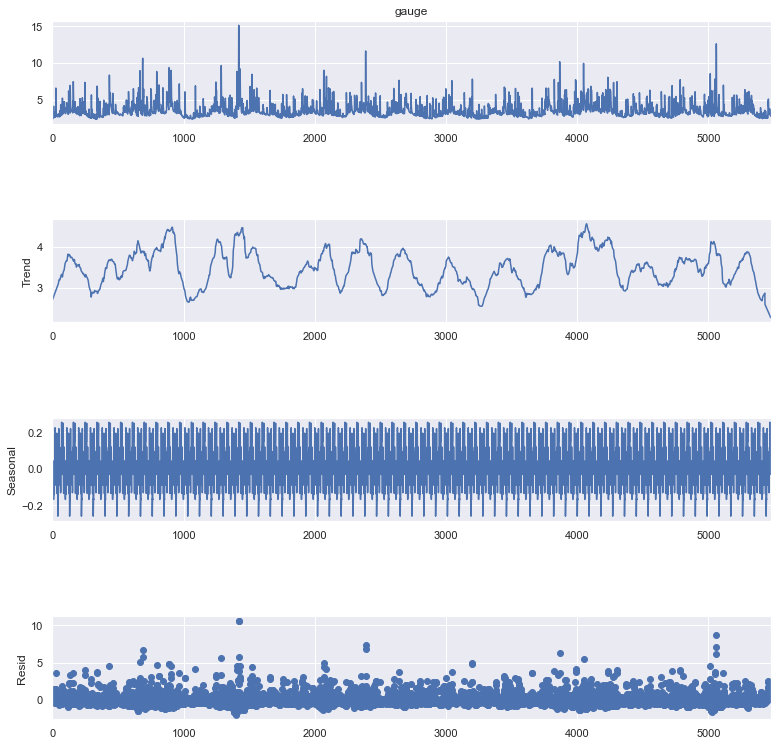

Gauge, Period: 180 Days


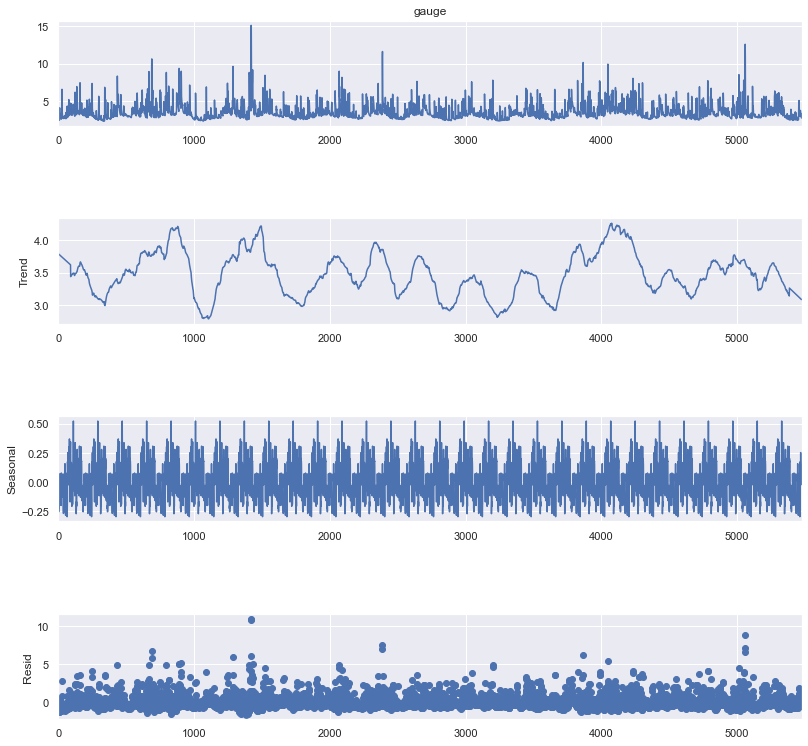

Gauge, Period: 365 Days


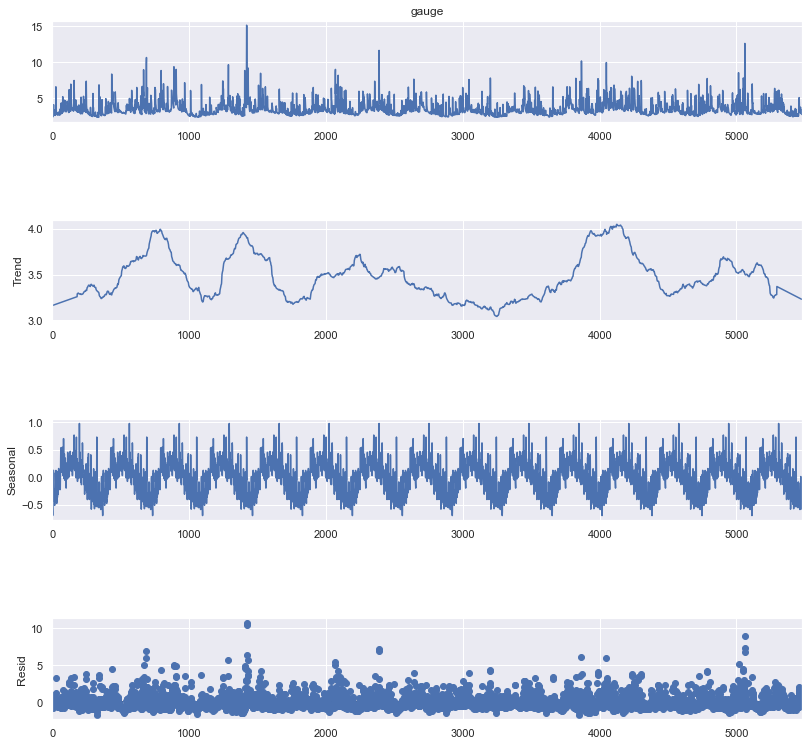

Gauge, Period: 730 Days


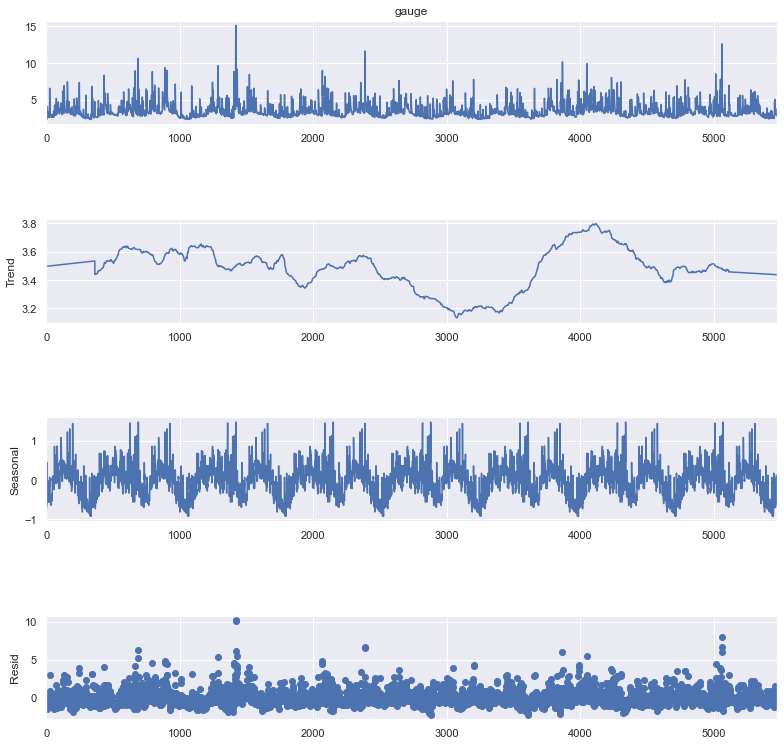

Gauge, Period: 1095 Days


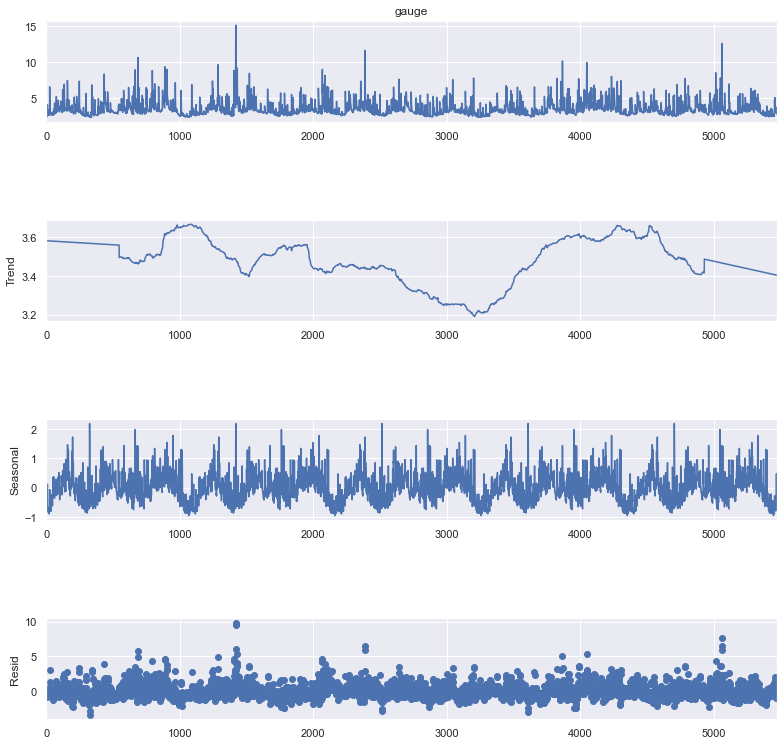

Gauge, Period: 1460 Days


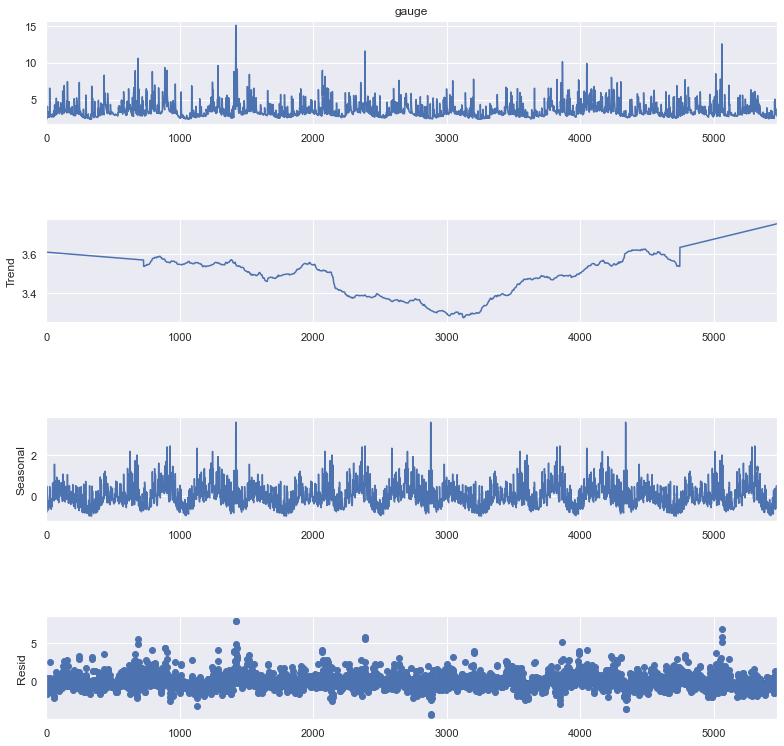

Gauge, Period: 1825 Days


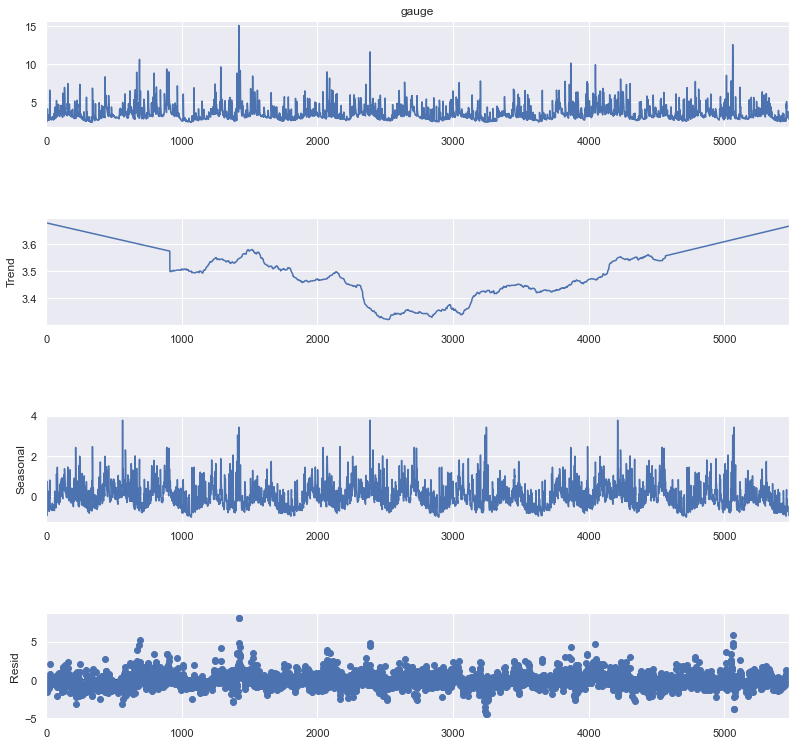

In [13]:
for period in periods:
	plot_decomp(period)

## Lag

We want to calculate each variable with a `shift()` (lag) to compare the correlation with the other variables.

You can see [documentation of shift function](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.shift.html) for more information.

In [15]:
days_in_month = 30

gauge[f'gauge_seasonal_shift_b_2m'] = gauge['gauge_seasonal'].shift(-2 * days_in_month)
gauge[f'gauge_seasonal_shift_b_1m'] = gauge['gauge_seasonal'].shift(-1 * days_in_month)
gauge[f'gauge_seasonal_shift_1m'] = gauge['gauge_seasonal'].shift(1 * days_in_month)
gauge[f'gauge_seasonal_shift_2m'] = gauge['gauge_seasonal'].shift(2 * days_in_month)
gauge[f'gauge_seasonal_shift_3m'] = gauge['gauge_seasonal'].shift(3 * days_in_month)

In [16]:
gauge.head()

,date,gauge,gauge_trend,gauge_seasonal,gauge_seasonal_shift_b_2m,gauge_seasonal_shift_b_1m,gauge_seasonal_shift_1m,gauge_seasonal_shift_2m,gauge_seasonal_shift_3m
0,2007-10-01,2.40,3.679807,-0.965451,-0.689281,-0.557635,NaN,NaN,NaN
1,2007-10-02,2.39,3.679692,-0.967812,-0.719148,-0.600899,NaN,NaN,NaN
2,2007-10-03,2.39,3.679577,-0.716861,-0.272357,-0.567540,NaN,NaN,NaN
3,2007-10-04,2.39,3.679462,-0.850161,0.251088,-0.510802,NaN,NaN,NaN
4,2007-10-05,2.42,3.679347,-0.776819,-0.225380,-0.577366,NaN,NaN,NaN


## Exploratory Data Analysis

Now, we'll plot the seasonality components and try to extract some knowledge.

In [17]:
gauge_3yr = gauge[gauge['date'] >= pd.Timestamp(2019,1,1)]
gauge_2020 = gauge[gauge['date'] >= pd.Timestamp(2020,1,1)]
gauge_2020 = gauge_2020[gauge_2020['date'] < pd.Timestamp(2021,1,1)]
gauge_2021 = gauge[gauge['date'] >= pd.Timestamp(2021,1,1)]
gauge_2021 = gauge_2021[gauge_2021['date'] < pd.Timestamp(2022,1,1)]

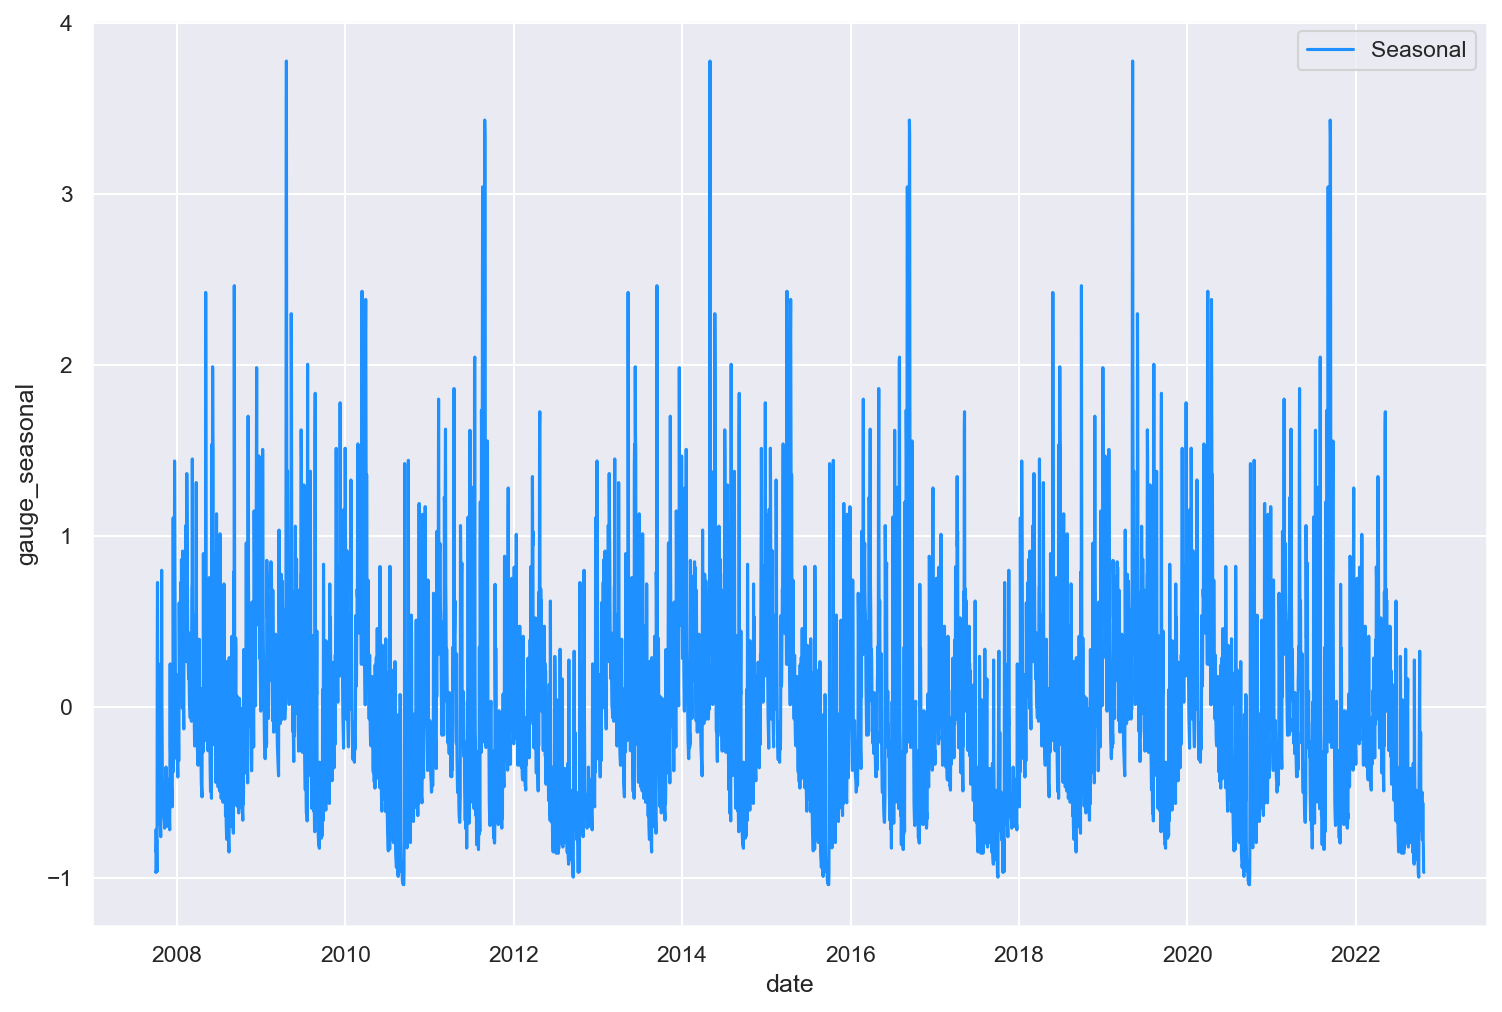

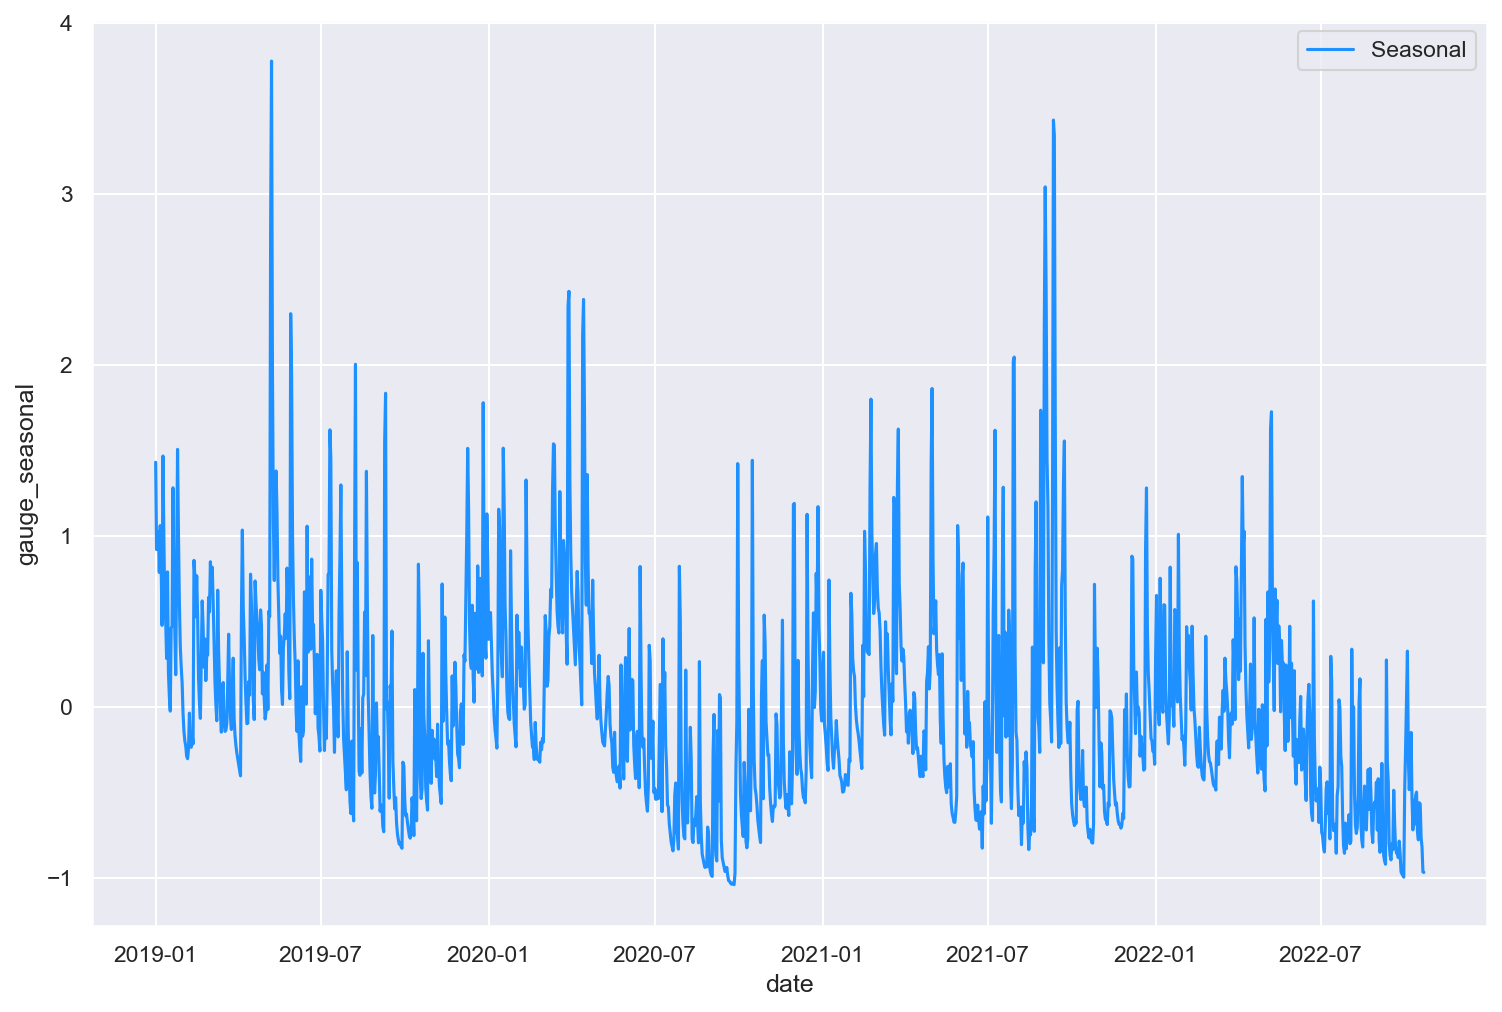

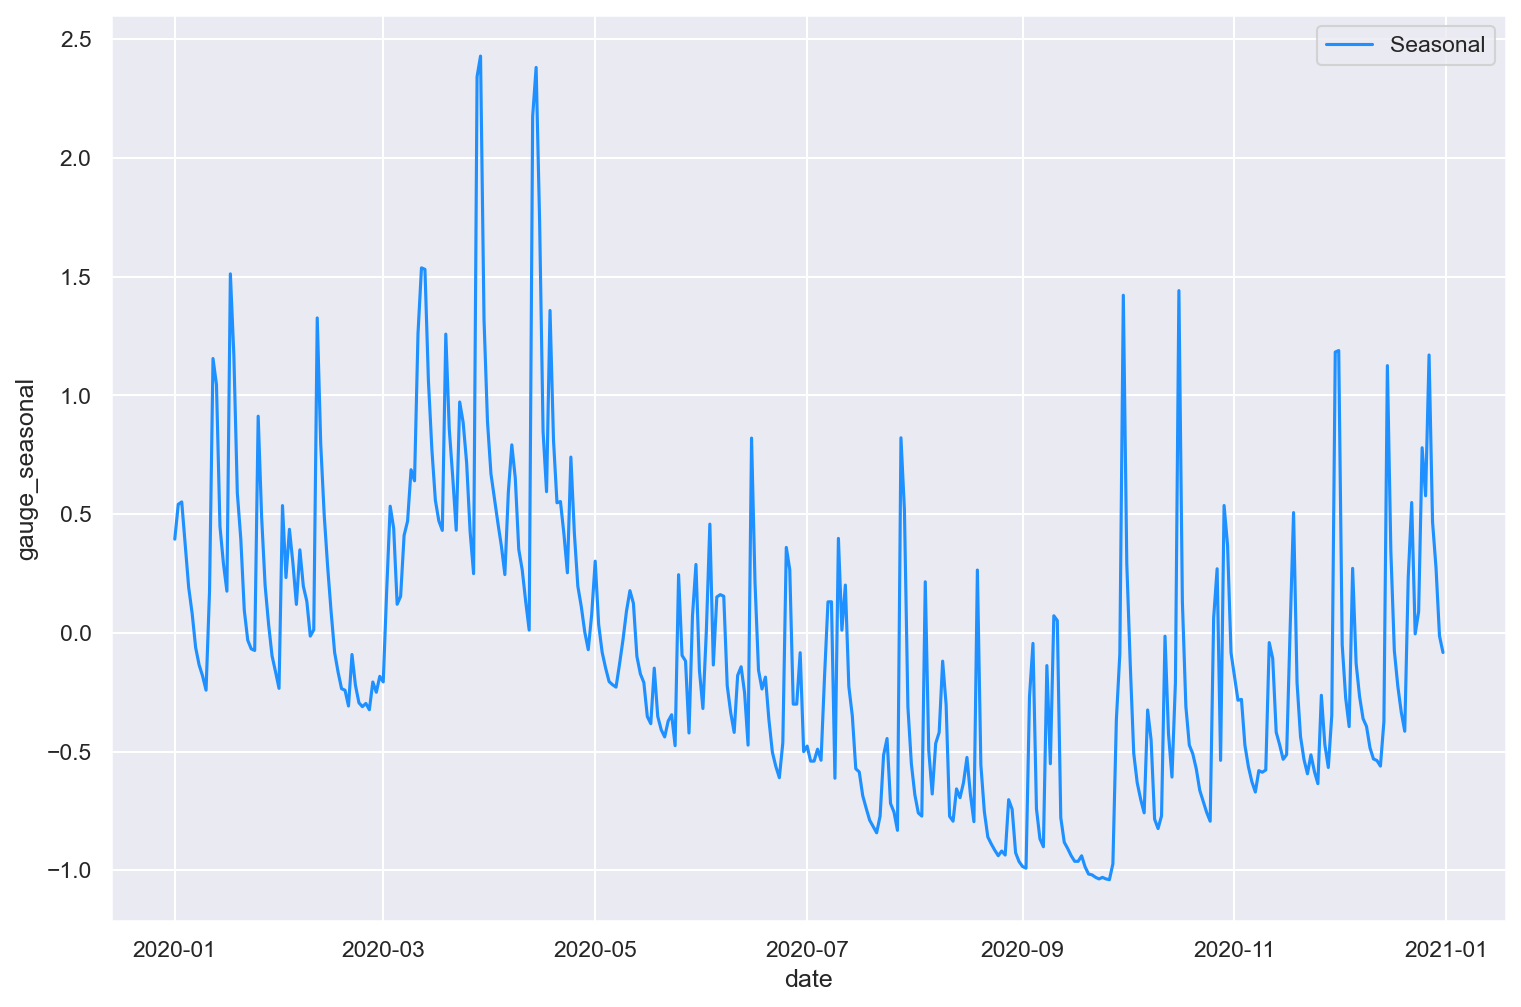

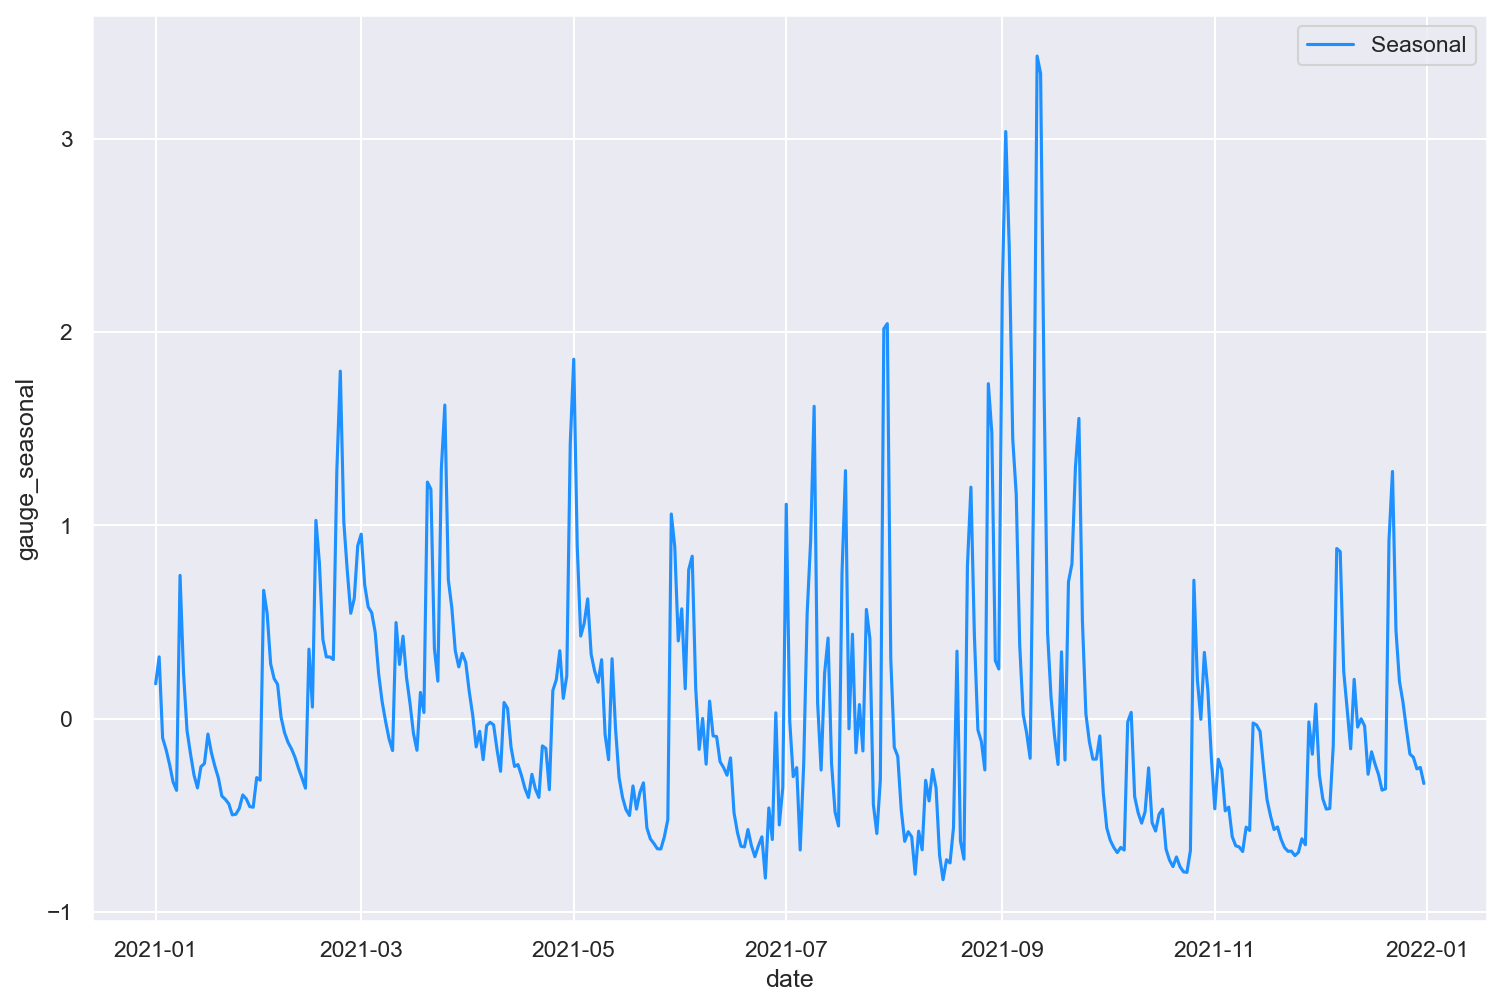

In [18]:
for df in [gauge, gauge_3yr, gauge_2020, gauge_2021]:
	plt.figure(figsize=(12,8), dpi=150)
	sns.lineplot(x=df['date'], y=df['gauge_seasonal'], color='dodgerblue', label='Seasonal')
	plt.show()

**Insights from Seasonality Plots**
Recent seasonal spikes

As we can see, the features are higher correlated in the case of shifted features (lagged ones) than the original ones.

## Autocorrelation Analysis

ACF and PACF plots: After a time series has been stationarized by differencing, the next step in fitting an ARIMA model is to determine whether AR or MA terms are needed to correct any autocorrelation that remains in the differenced series. Of course, with software like Statgraphics, you could just try some different combinations of terms and see what works best. But there is a more systematic way to do this. By looking at the **autocorrelation function (ACF)** and **partial autocorrelation (PACF)** plots of the differenced series, you can tentatively identify the numbers of AR and/or MA terms that are needed.

* **Autocorrelation Function (ACF)**: P = Periods to lag for eg: (if P= 3 then we will use the three previous periods of our time series in the autoregressive portion of the calculation) P helps adjust the line that is being fitted to forecast the series. P corresponds with MA parameter
* **Partial Autocorrelation Function (PACF)**: D = In an ARIMA model we transform a time series into stationary one(series without trend or seasonality) using differencing. D refers to the number of differencing transformations required by the time series to get stationary. D corresponds with AR parameter.

Autocorrelation plots help in detecting seasonality.

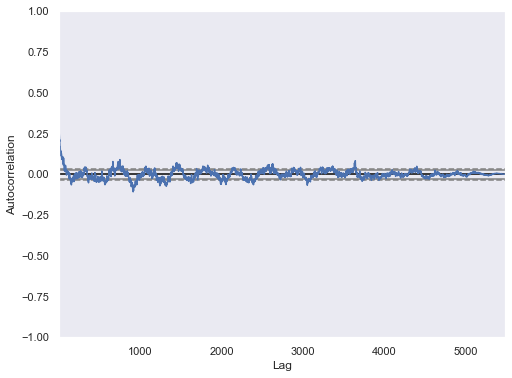

In [19]:
plt.gcf().set_size_inches(8, 6)
autocorrelation_plot(gauge['gauge'])
plt.show()

<Figure size 1200x900 with 0 Axes>

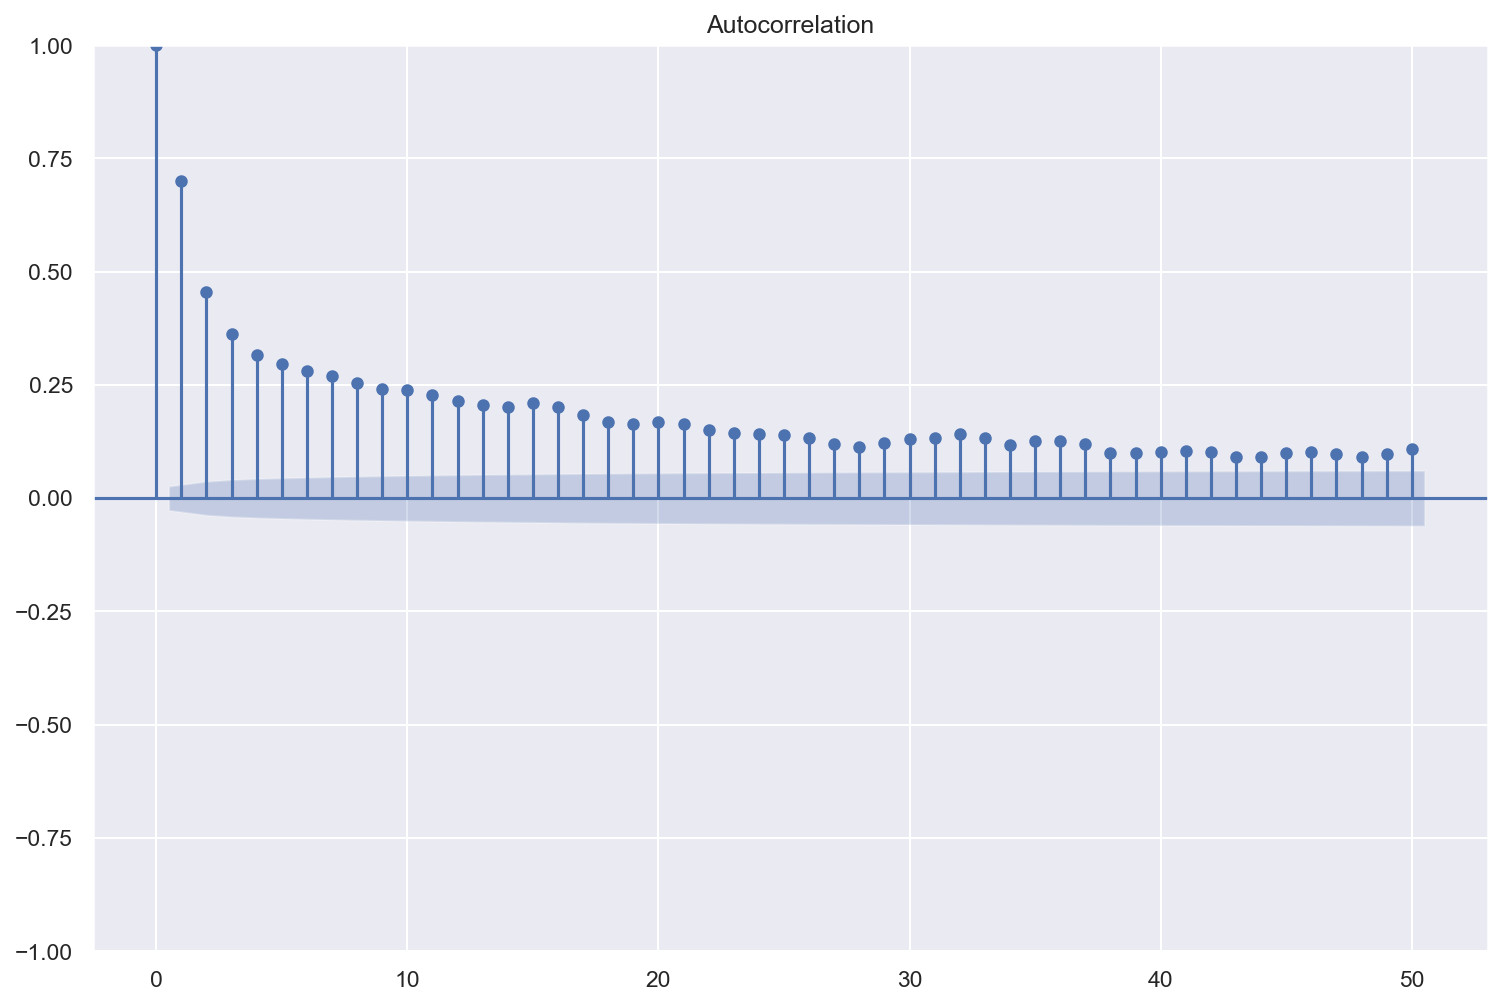

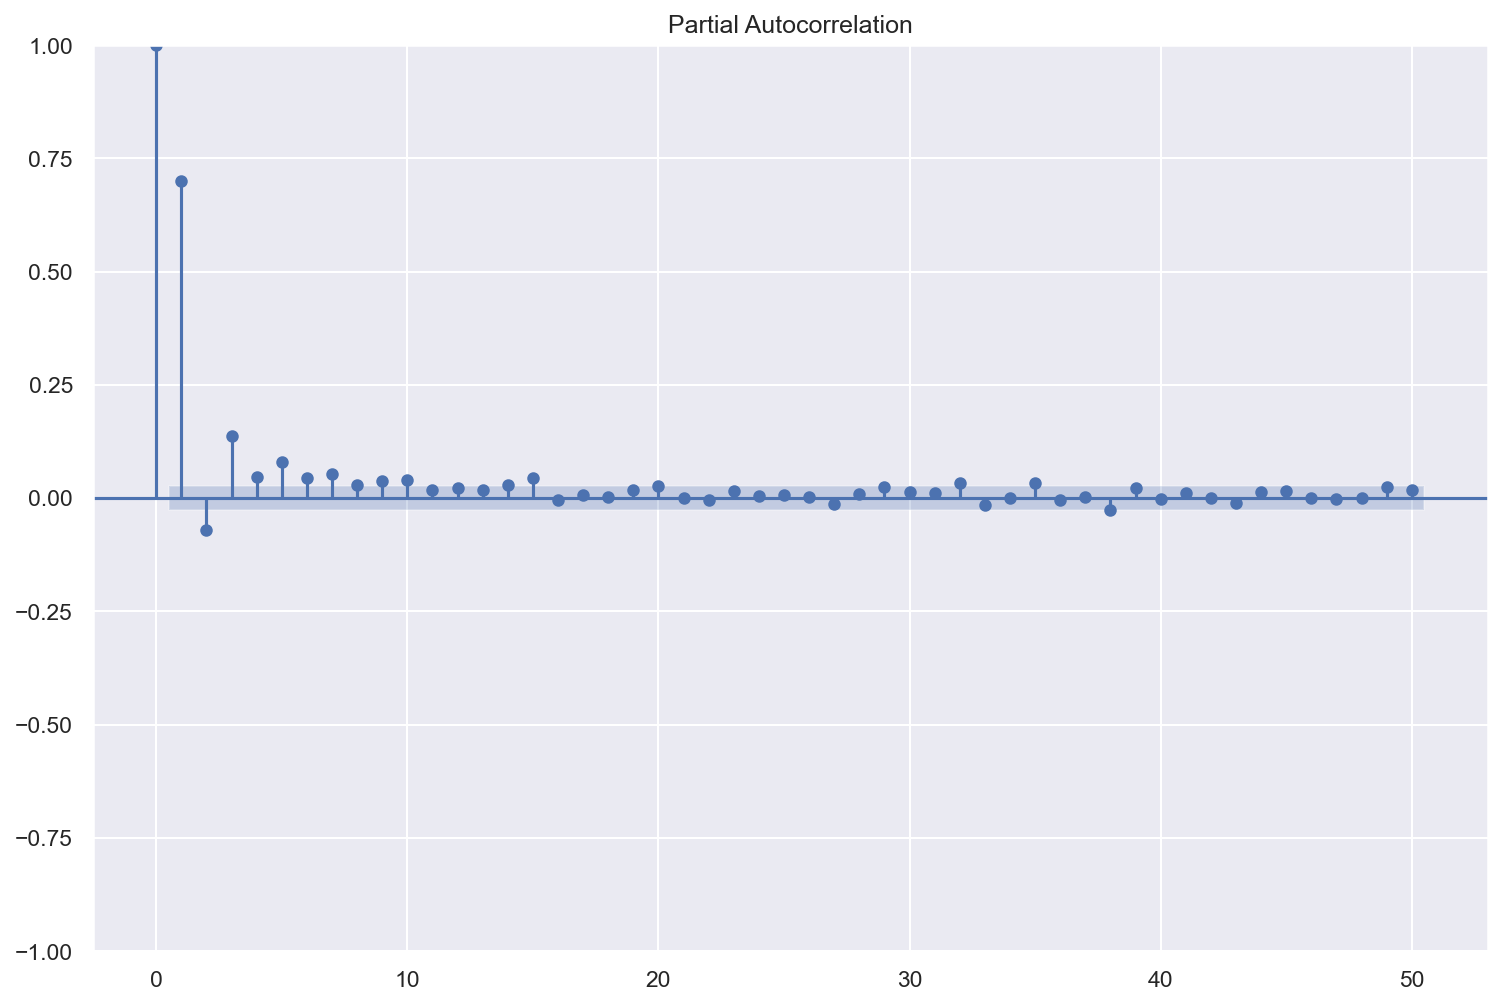

<Figure size 1200x900 with 0 Axes>

In [46]:
plot_acf(gauge['gauge'], lags=50)
plt.gcf().set_size_inches(12, 8)
plot_pacf(gauge['gauge'], lags=50)
plt.gcf().set_size_inches(12, 8)
plt.figure(figsize=(8, 6), dpi=150)

## Modeling

Time series can be either univariate or multivariate:

* **Univariate** time series only has a single time-dependent variable.
* **Multivariate** time series have a multiple time-dependent variable.

But first we'll explore cross-validation in Time Series Analysis. 

In [21]:
N_SPLITS = 3

X = gauge['date']
y = gauge['gauge']

folds = TimeSeriesSplit(n_splits=N_SPLITS)

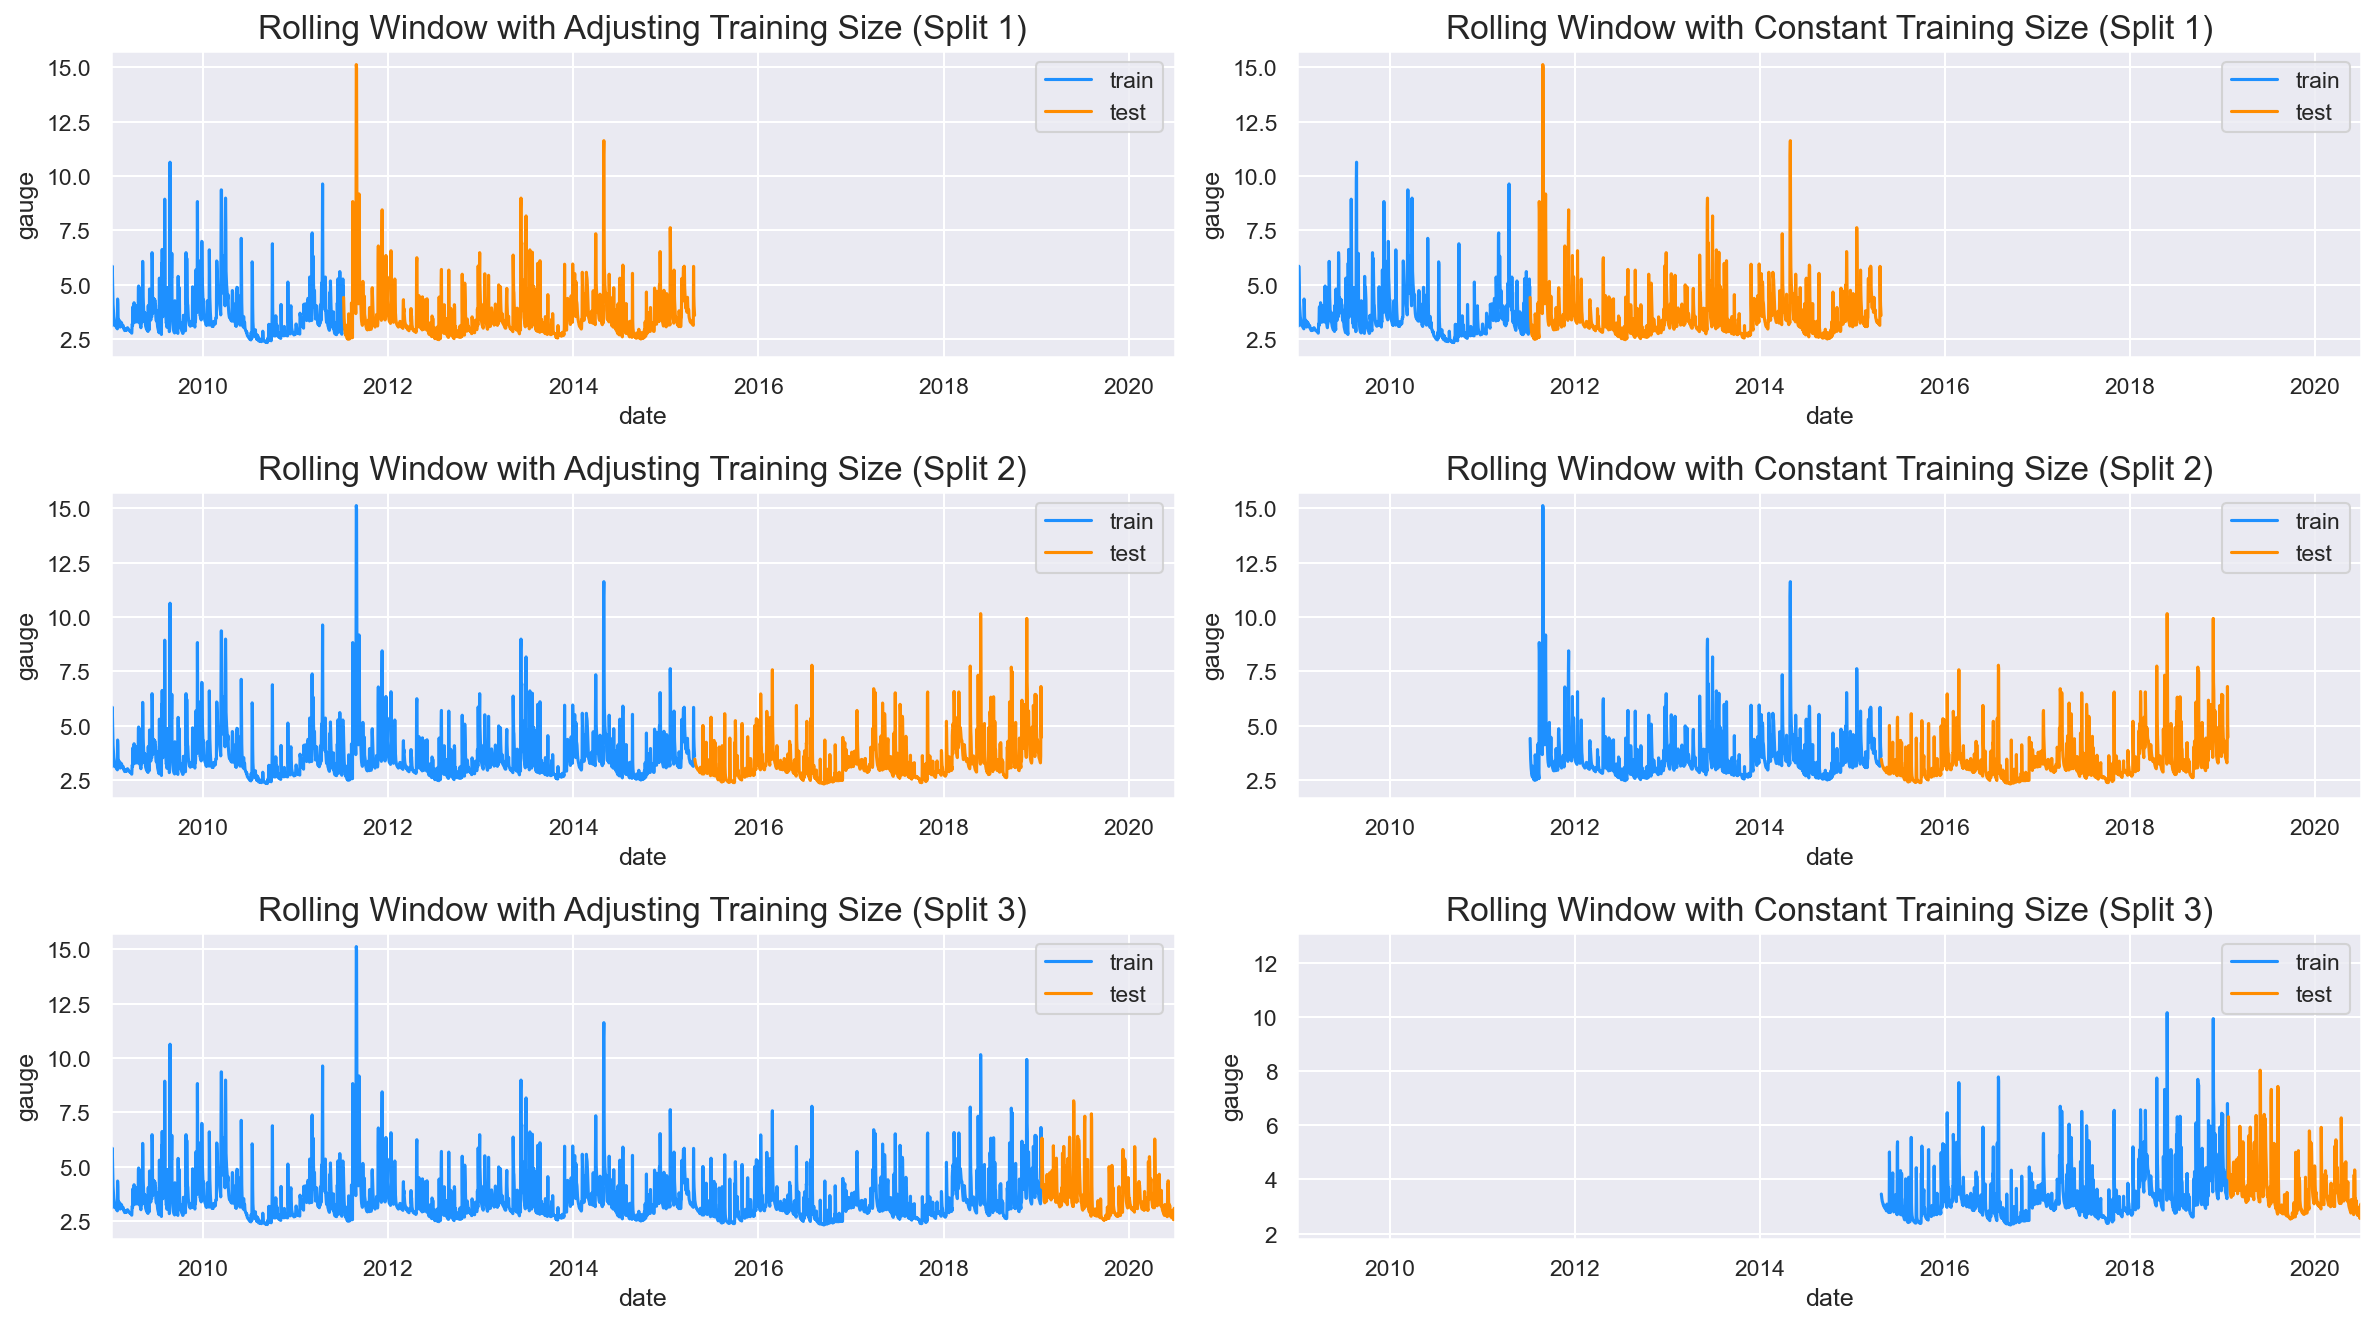

In [50]:
f, ax = plt.subplots(nrows=N_SPLITS, ncols=2, figsize=(16, 9))

for i, (train_index, test_index) in enumerate(folds.split(X)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    sns.lineplot(
        x=X_train, 
        y=y_train, 
        ax=ax[i,0], 
        color='dodgerblue', 
        label='train'
    )
    sns.lineplot(
        x=X_train[len(X_train) - len(X_test):(len(X_train) - len(X_test) + len(X_test))], 
        y=y_train[len(X_train) - len(X_test):(len(X_train) - len(X_test) + len(X_test))], 
        ax=ax[i,1], 
        color='dodgerblue', 
        label='train'
    )

    for j in range(2):
        sns.lineplot(x= X_test, y= y_test, ax=ax[i, j], color='darkorange', label='test')
    ax[i, 0].set_title(f"Rolling Window with Adjusting Training Size (Split {i+1})", fontsize=16)
    ax[i, 1].set_title(f"Rolling Window with Constant Training Size (Split {i+1})", fontsize=16)

for i in range(N_SPLITS):
    ax[i, 0].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])
    ax[i, 1].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])
    
plt.tight_layout()
plt.show()

The idea with this plot is to understand which train and test set are we using to fit the model in each iteration. 

## Models for Univariate Time Series

**Univariate time series**: Only one variable is varying over time. For example, data collected from a sensor measuring the temperature of a room every second. Therefore, each second, you will only have a one-dimensional value, which is the temperature.

In [47]:
train_size = int(0.85 * len(df))
test_size = len(df) - train_size

univariate_df = gauge[['date', 'gauge']].copy()
univariate_df.columns = ['ds', 'y']

train = univariate_df.iloc[:train_size, :]

x_train, y_train = pd.DataFrame(univariate_df.iloc[:train_size, 0]), pd.DataFrame(univariate_df.iloc[:train_size, 1])
x_test, y_test = pd.DataFrame(univariate_df.iloc[train_size:, 0]), pd.DataFrame(univariate_df.iloc[train_size:, 1])

print(len(train), len(x_test))

310 5167


# SARIMA Modeling
Seasonal Autoregressive Integrated Moving Average Model; SARIMA(p, d, q)(P, D, Q)

For our model, we won't be using differencing (integration).

Instead, our challenge lies in choosing the correct seasonality parameter (by month, by week, etc.).

For now, we'll loop through the different periods used in the decomposition loop:
<pre>
# 1 week, 2 weeks, 1 month, 3 months, 6 months, 1 year, 2, 3, 4, 5 years
periods = [7, 14, 30, 90, 180, 365, 730, 1095, 1460, 1825]
</pre>

In [78]:
def optimize_SARIMA(parameters_list, s, exog):
    """
        Return dataframe with parameters, corresponding AIC and SSE
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order
        D - seasonal integration order
        s - length of season
        exog - the exogenous variable
    """
    
    results = []
    
    for param in parameters_list:
        try: 
            model = SARIMAX(exog, order=(param[0], 0, param[1]), seasonal_order=(param[2], 0, param[3], s)).fit(disp=-1)
        except:
            continue
            
        aic = model.aic
        results.append([param, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)x(P,Q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [79]:
p = range(0, 4, 1)
d = 0
q = range(0, 4, 1)
P = range(0, 4, 1)
D = 0
Q = range(0, 4, 1)
s = periods.copy()
parameters = product(p, q, P, Q)
parameters_list = list(parameters)
print(len(parameters_list))

256


In [ ]:
results = optimize_SARIMA(parameters_list, 4, gauge['gauge'])
results['seasonality'] = f'{seasonality} days'
results